# <u><center>PCA Exercise (Core)
* Authored By: Eric N. Valdez
* Date: 2/28/24

# <u>Task

Your task is to compare a default KNeighborsClassifier's speed and performance for a non-PCA dataset and a PCA dataset.

# <u>Imports

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as mnso

from seaborn import heatmap

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns',100)
pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

set_config(transform_output='pandas')
np.random.seed(42)



# <u>Custom Functions

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
def eval_classification(model, X_train, X_test, y_train, y_test):
  print('Train Report:', classification_report(y_train, model.predict(X_train)))
  print('Test Report:', classification_report(y_test, model.predict(X_test)))

  cm = confusion_matrix(y_test, model.predict(X_test))

  plt.figure(figsize=(15, 15))
  heatmap(cm, annot=True)
  plt.xlabel('Predicted', fontsize=40)
  plt.ylabel('True', fontsize=40)
  plt.show()

## `1. Load the Data`
This dataset is a modified version of the NHANES dataset found on Kaggle. Download the data [here​.](https://drive.google.com/file/d/1CE2giLLTp0Cjn0bn9hmtCWIxGZf8_uO1/view)

The target for this dataset i**s 'Diabetes_Risk**.' The features are survey responses related to the person's diet. All of the features are numerical.

In [4]:
df = pd.read_csv('Data/NHANES_Diet_Diabetes_Risk.xls.csv')
df.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V,Diabetes_Risk
0,73557,16888.32786,12930.89065,1,49.0,2.0,2.0,6.0,2.0,1.0,1.0,13.0,3.0,2.0,4.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1574.0,43.63,239.59,176.47,10.8,52.81,17.819,18.493,8.829,209.0,3.92,0.0,70.0,110.0,60.0,304.0,278.0,1398.0,430.0,1.057,1.216,11.804,0.951,285.0,66.0,219.0,330.0,216.3,2.79,0.00,241.4,3.3,29.2,949.0,756.0,206.0,8.41,8.85,1.072,1323.0,2228.0,62.5,203.0,36.0,0.0,2701.79,0.219,0.099,0.103,0.153,0.346,1.221,9.694,5.408,1.173,16.796,0.121,0.001,7.932,0.769,0.000,0.094,0.001,0.000,0.010,2.0,960.0,960.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,73558,17932.14387,12684.14887,1,59.0,2.0,2.0,4.0,1.0,1.0,1.0,13.0,1.0,2.0,3.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,5062.0,338.13,423.78,44.99,16.7,124.29,53.408,35.481,20.505,2584.0,20.94,0.0,1477.0,1488.0,0.0,145.0,12.0,0.0,899.0,4.178,5.168,65.396,4.415,1243.0,601.0,641.0,1662.0,2149.0,21.45,0.00,2.3,15.2,23.4,3193.0,6427.0,903.0,26.88,30.36,4.130,9726.0,4930.0,715.8,240.0,0.0,119.0,6779.99,1.872,1.160,0.802,1.286,1.297,6.516,27.952,12.107,2.208,32.429,0.086,0.000,15.483,1.774,0.007,0.728,1.003,0.104,1.139,2.0,360.0,360.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2
2,73559,59641.81293,39394.23671,1,49.0,2.0,2.0,18.0,6.0,1.0,1.0,13.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,1743.0,64.61,224.39,102.90,9.9,65.97,25.263,20.902,12.953,88.0,8.87,0.0,616.0,655.0,21.0,449.0,35.0,515.0,300.0,1.648,1.747,18.342,1.906,423.0,290.0,133.0,625.0,161.2,3.78,1.42,195.1,4.0,40.4,877.0,1198.0,210.0,17.57,8.98,0.949,2943.0,1694.0,98.3,45.0,71.0,0.0,3766.70,0.358,0.128,0.371,0.455,3.008,2.067,10.691,7.497,0.531,19.910,0.164,0.005,11.705,1.092,0.000,0.042,0.001,0.006,0.002,2.0,1254.0,0.0,1254.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,73561,59052.35703,39004.89299,1,63.0,2.0,2.0,18.0,1.0,1.0,1.0,13.0,4.0,Na

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6643 entries, 0 to 6642
Data columns (total 169 columns):
 #    Column         Dtype  
---   ------         -----  
 0    SEQN           int64  
 1    WTDRD1         float64
 2    WTDR2D         float64
 3    DR1DRSTZ       int64  
 4    DR1EXMER       float64
 5    DRABF          float64
 6    DRDINT         float64
 7    DR1DBIH        float64
 8    DR1DAY         float64
 9    DR1LANG        float64
 10   DR1MNRSP       float64
 11   DR1HELPD       float64
 12   DBQ095Z        float64
 13   DBD100         float64
 14   DRQSPREP       float64
 15   DR1STY         float64
 16   DR1SKY         float64
 17   DRQSDIET       float64
 18   DRQSDT1        float64
 19   DRQSDT2        float64
 20   DRQSDT3        float64
 21   DRQSDT4        float64
 22   DRQSDT5        float64
 23   DRQSDT6        float64
 24   DRQSDT7        float64
 25   DRQSDT8        float64
 26   DRQSDT9        float64
 27   DRQSDT10       float64
 28   DRQSDT11       f

In [6]:
df.shape

(6643, 169)

In [7]:
# Define X and y
target = "Diabetes_Risk"
X = df.drop(columns = target)
y = df[target]

## `2. Preprocess the Data`
### Set SEQN as the index

In [8]:
# Checking over the value counts
df.dtypes.value_counts()

float64    166
int64        3
dtype: int64

In [9]:
# Checking current index
df.index

RangeIndex(start=0, stop=6643, step=1)

In [10]:
# Set the index to the 'Name' column
df.set_index('SEQN', inplace=True)
print(df)

            WTDRD1        WTDR2D  DR1DRSTZ  DR1EXMER  DRABF  DRDINT  DR1DBIH  \
SEQN                                                                           
73557  16888.32786  12930.890650         1      49.0    2.0     2.0      6.0   
73558  17932.14387  12684.148870         1      59.0    2.0     2.0      4.0   
73559  59641.81293  39394.236710         1      49.0    2.0     2.0     18.0   
73561  59052.35703  39004.892990         1      63.0    2.0     2.0     18.0   
73562  49890.82866      0.000000         1      49.0    2.0     1.0     11.0   
...            ...           ...       ...       ...    ...     ...      ...   
83721  50162.97146  35482.349600         1      49.0    2.0     2.0      6.0   
83723  14116.87893   9661.836186         1      49.0    2.0     2.0     21.0   
83724  32115.84947  46169.498760         1      54.0    2.0     2.0     10.0   
83727  14146.78133  10520.302070         1      59.0    2.0     2.0      8.0   
83729  15272.50520  10401.781170        

In [11]:
# Checking to see change in index
df.index

Int64Index([73557, 73558, 73559, 73561, 73562, 73564, 73566, 73567, 73568,
            73571,
            ...
            83715, 83716, 83717, 83718, 83720, 83721, 83723, 83724, 83727,
            83729],
           dtype='int64', name='SEQN', length=6643)

### Train Test Split

In [12]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
3332,78727,70710.30601,46705.128430,1,59.0,2.0,2.0,1.0,7.0,1.0,1.0,13.0,4.0,NaN,3.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1339.0,50.73,211.40,77.68,15.8,34.75,11.780,10.515,8.776,63.0,2.54,0.0,246.0,294.0,164.0,509.0,7.0,303.0,827.0,1.320,1.811,17.034,1.509,416.0,207.0,209.0,560.0,147.9,3.29,1.4,139.6,2.7,95.9,629.0,845.0,215.0,16.77,7.06,1.037,2251.0,1820.0,74.8,97.0,30.0,0.0,2021.37,0.254,0.140,0.094,0.182,0.233,0.943,6.558,2.773,0.449,7.519,0.088,0.016,7.917,0.814,0.000,0.018,0.000,0.000,0.000,1.0,960.0,0.0,960.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,1.0,5.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
5677,82233,60907.62017,88806.191190,1,25.0,2.0,2.0,0.0,5.0,1.0,1.0,13.0,3.0,3.0,1.0,1.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,858.0,45.09,105.41,16.39,5.7,27.83,9.012,9.554,6.515,253.0,1.96,0.0,226.0,233.0,0.0,97.0,5.0,448.0,424.0,3.000,2.110,15.608,0.758,276.0,177.0,97.0,399.0,223.5,1.03,0.0,3.5,2.3,12.3,759.0,833.0,156.0,7.39,3.87,0.516,1524.0,1265.0,92.1,288.0,0.0,0.0,4181.51,0.234,0.143,0.086,0.185,0.198,0.664,5.207,2.191,0.390,8.977,0.055,0.002,5.875,0.389,0.000,0.131,0.002,0.007,0.033,2.0,1521.0,0.0,1521.0,4.0,1.0,2.0,NaN,1.0,2.0,2.0,NaN,1.0,2.0,2.0,NaN,2.0,NaN,2.0,NaN,1.0,4.0,2.0,NaN,2.0,NaN,2.0,1.0,2.0,NaN,1.0,3.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,4.0,2.0,NaN,2.0
307,74032,46703.93997,173276.611500,1,2.0,2.0,2.0,3.0,1.0,1.0,1.0,13.0,4.0,NaN,3.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,1356.0,59.90,167.90,115.17,5.2,50.45,23.208,15.741,4.577,166.0,1.83,0.0,249.0,266.0,39.0,181.0,16.0,1809.0,83.0,0.567,1.865,8.027,1.200,127.0,50.0,77.0,160.0,194.0,5.51,0.0,20.5,1.4,23.1,1059.0,1091.0,163.0,6.02,9.06,0.573,2110.0,1932.0,62.7,52.0,109.0,0.0,2263.56,0.683,0.397,0.240,0.554,0.647,2.603,11.196,6.093,0.823,9.511,0.095,0.000,4.053,0.427,0.001,0.069,0.003,0.006,0.001,2.0,1275.0,1275.0,0.0,1.0,1.0,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,2.0,NaN,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3550,79069,10390.35346,8097.175852,1,2.0,2.0,2.0,11.0,7.0,1.0,1.0,13.0,4.0,NaN,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Na

### Impute Missing Values with the median value

In [13]:
# Check missing values
X.isna().sum().sum()

432597

In [14]:
# Fill in nulls with 0 and verify all nulls are addressed
X = X.fillna(0)
X.isna().sum().sum()

0

In [15]:
# rechecking Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
3332,78727,70710.30601,46705.128430,1,59.0,2.0,2.0,1.0,7.0,1.0,1.0,13.0,4.0,0.0,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,1339.0,50.73,211.40,77.68,15.8,34.75,11.780,10.515,8.776,63.0,2.54,0.0,246.0,294.0,164.0,509.0,7.0,303.0,827.0,1.320,1.811,17.034,1.509,416.0,207.0,209.0,560.0,147.9,3.29,1.4,139.6,2.7,95.9,629.0,845.0,215.0,16.77,7.06,1.037,2251.0,1820.0,74.8,97.0,30.0,0.0,2021.37,0.254,0.140,0.094,0.182,0.233,0.943,6.558,2.773,0.449,7.519,0.088,0.016,7.917,0.814,0.000,0.018,0.000,0.000,0.000,1.0,960.0,0.0,960.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,5.0,2.0,0.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
5677,82233,60907.62017,88806.191190,1,25.0,2.0,2.0,0.0,5.0,1.0,1.0,13.0,3.0,3.0,1.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,858.0,45.09,105.41,16.39,5.7,27.83,9.012,9.554,6.515,253.0,1.96,0.0,226.0,233.0,0.0,97.0,5.0,448.0,424.0,3.000,2.110,15.608,0.758,276.0,177.0,97.0,399.0,223.5,1.03,0.0,3.5,2.3,12.3,759.0,833.0,156.0,7.39,3.87,0.516,1524.0,1265.0,92.1,288.0,0.0,0.0,4181.51,0.234,0.143,0.086,0.185,0.198,0.664,5.207,2.191,0.390,8.977,0.055,0.002,5.875,0.389,0.000,0.131,0.002,0.007,0.033,2.0,1521.0,0.0,1521.0,4.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,4.0,2.0,0.0,2.0,0.0,2.0,1.0,2.0,0.0,1.0,3.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,4.0,2.0,0.0,2.0
307,74032,46703.93997,173276.611500,1,2.0,2.0,2.0,3.0,1.0,1.0,1.0,13.0,4.0,0.0,3.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,1356.0,59.90,167.90,115.17,5.2,50.45,23.208,15.741,4.577,166.0,1.83,0.0,249.0,266.0,39.0,181.0,16.0,1809.0,83.0,0.567,1.865,8.027,1.200,127.0,50.0,77.0,160.0,194.0,5.51,0.0,20.5,1.4,23.1,1059.0,1091.0,163.0,6.02,9.06,0.573,2110.0,1932.0,62.7,52.0,109.0,0.0,2263.56,0.683,0.397,0.240,0.554,0.647,2.603,11.196,6.093,0.823,9.511,0.095,0.000,4.053,0.427,0.001,0.069,0.003,0.006,0.001,2.0,1275.0,1275.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3550,79069,10390.35346,8097.175852,1,2.0,2.0,2.0,11.0,7.0,1.0,1.0,13.0,4.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Scale

In [16]:
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
scaled_df = scaler.fit_transform(X)
scaled_df.head()

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,DBD100,DRQSPREP,DR1STY,DR1SKY,DRQSDIET,DRQSDT1,DRQSDT2,DRQSDT3,DRQSDT4,DRQSDT5,DRQSDT6,DRQSDT7,DRQSDT8,DRQSDT9,DRQSDT10,DRQSDT11,DRQSDT12,DRQSDT91,DR1TNUMF,DR1TKCAL,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,DR1TPFAT,DR1TCHOL,DR1TATOC,DR1TATOA,DR1TRET,DR1TVARA,DR1TACAR,DR1TBCAR,DR1TCRYP,DR1TLYCO,DR1TLZ,DR1TVB1,DR1TVB2,DR1TNIAC,DR1TVB6,DR1TFOLA,DR1TFA,DR1TFF,DR1TFDFE,DR1TCHL,DR1TVB12,DR1TB12A,DR1TVC,DR1TVD,DR1TVK,DR1TCALC,DR1TPHOS,DR1TMAGN,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1TMOIS,DR1TS040,DR1TS060,DR1TS080,DR1TS100,DR1TS120,DR1TS140,DR1TS160,DR1TS180,DR1TM161,DR1TM181,DR1TM201,DR1TM221,DR1TP182,DR1TP183,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1.300,DR1.320Z,DR1.330Z,DR1BWATZ,DR1TWS,DRD340,DRD350A,DRD350AQ,DRD350B,DRD350BQ,DRD350C,DRD350CQ,DRD350D,DRD350DQ,DRD350E,DRD350EQ,DRD350F,DRD350FQ,DRD350G,DRD350GQ,DRD350H,DRD350HQ,DRD350I,DRD350IQ,DRD350J,DRD350JQ,DRD350K,DRD360,DRD370A,DRD370AQ,DRD370B,DRD370BQ,DRD370C,DRD370CQ,DRD370D,DRD370DQ,DRD370E,DRD370EQ,DRD370F,DRD370FQ,DRD370G,DRD370GQ,DRD370H,DRD370HQ,DRD370I,DRD370IQ,DRD370J,DRD370JQ,DRD370K,DRD370KQ,DRD370L,DRD370LQ,DRD370M,DRD370MQ,DRD370N,DRD370NQ,DRD370O,DRD370OQ,DRD370P,DRD370PQ,DRD370Q,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,-1.752448,-0.545998,-0.459880,-0.296272,0.383239,0.303118,0.447571,-0.712801,-0.878955,-0.101899,0.068907,0.314534,-0.020175,0.836521,0.709600,0.348049,-0.090797,0.327071,-0.279704,-0.136208,-0.130954,-0.071725,0.0,-0.017354,-0.145112,-0.050652,-0.095469,-0.056314,-0.061462,-0.032478,-0.087085,-0.434747,-0.308152,-0.618228,0.049798,0.914479,-0.393230,-0.414249,-0.342634,-0.385175,-0.620438,-0.236110,-0.526102,-0.187241,-0.769101,-0.766720,-0.250930,-0.378914,0.530132,-0.371660,-0.282323,-0.408698,-0.467362,-0.646891,-0.534891,-0.280803,-0.525847,0.150456,-0.377784,-0.379829,-0.331280,-0.325162,1.901257,-0.170426,-0.451776,0.140185,-0.619868,-0.346805,-0.511374,-0.153430,-0.008700,-0.925196,-0.062164,-0.577547,0.527830,0.016225,-0.305989,0.127339,-0.451971,-0.577336,-0.480689,-0.649821,-0.328474,-0.400708,-0.356374,-0.084053,0.237317,-0.375256,-0.551468,-0.270022,-0.601985,-0.592087,-0.276295,-0.359184,-0.274588,-0.598099,-0.275403,0.003371,-0.011834,0.471064,-0.505719,-0.243323,0.643465,-0.888550,-0.203746,-0.872868,-0.25639,-0.903007,-0.101643,-0.889305,-0.197793,-0.898048,-0.165050,-0.896091,-0.142436,-0.891842,-0.181218,-0.847261,-0.52117,-0.900879,-0.137948,-0.912790,-0.040661,-0.913551,0.814272,-1.181323,-0.211375,-1.102695,-0.362662,-1.212297,-0.092276,-1.162667,-0.25877,-1.178258,-0.220956,-1.200521,-0.138514,-1.206455,-0.12495,-1.213795,-0.08252,-1.213983,-0.096416,-1.220798,-0.03544,-1.210340,-0.095130,-1.218798,-0.057327,-1.108121,-0.362764,-1.203887,-0.117442,-1.214358,-0.087854,-1.220989,-0.03071,-1.216430,-0.067606,-1.207468,-0.126706,-1.219559,-0.040193,-1.139121,-0.27258,-1.196738,-0.12403,-1.221371
1,-1.752106,-0.519370,-0.464346,-0.296272,0.820191,0.303118,0.447571,-0.879130,-1.295039,-0.101899,0.068907,0.314534,-0.186349,0.836521,0.027715,-0.817319,0.146203,0.327071,-0.279704,-0.136208,-0.130954,-0.071725,0.0,-0.017354,-0.145112,-0.050652,-0.095469,-0.056314,-0.061462,-0.032478,-0.087085,-0.845445,2.752878,5.218095,1.346450,-0.703210,0.135432,0.985104,1.689169,0.518989,0.225679,9.195179,1.629272,-0.187241,2.781440,1.645351,-0.305931,-0.417148,-0.184009,-0.544414,-0.140560,2.712851,2.299044,2.285557,1.360528,3.219905,2.283578,2.872203,3.020616,8.280592,3.344530,-0.325162,-0.791097,1.894228,-0.487591,3.691912,6.569322,3.744788,1.463183,2.737355,3.872045,3.239787,1.865318,8.108167,0.746111,-0.405133,4.526293,2.646123,2.998478,2.917530,2.137870,1.857625,0.441889,2.442051,1.597493,1.470889,1.460583,0.527473,-0.662962,-0.280706,0.009648,0.121382,-0.072219,3.970896,9.448452,2.150585,5.750670,0.003371,-0.528572,-0.16395

## `3. Model - No PCA`
* ### ​Fit a default KNN model to the data.

In [17]:
%%time
# Without PCA
knn = KNeighborsClassifier()
scaler = StandardScaler()
# Now we will build the pipeline
knn_no_pca_pipe = make_pipeline(scaler, knn)
knn_no_pca_pipe.fit(X_train, y_train)

CPU times: total: 31.2 ms
Wall time: 37.8 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

* ### Once fit, record the time it takes to make the predictions by using %%time as shown in the example below.

In [57]:
%%time
preds = knn.predict(X_train)

CPU times: total: 1.91 s
Wall time: 829 ms


# Record the time it takes to make predictions


* ### Evaluate the model using multiple appropriate metrics `(we recommend using a custom evaluation function)`.​

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4085
           1       0.49      0.05      0.10       437
           2       0.79      0.14      0.24       460

    accuracy                           0.83      4982
   macro avg       0.71      0.40      0.41      4982
weighted avg       0.80      0.83      0.78      4982



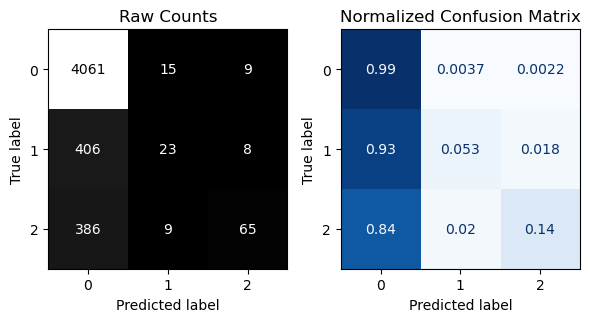


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1367
           1       0.36      0.03      0.06       150
           2       0.44      0.08      0.14       144

    accuracy                           0.82      1661
   macro avg       0.54      0.37      0.37      1661
weighted avg       0.76      0.82      0.76      1661



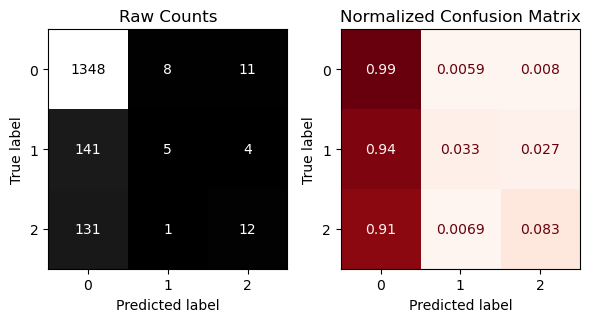

In [19]:
# evaluate the pipeline
evaluate_classification(knn_no_pca_pipe, X_train, y_train, X_test, y_test)

## `4. Transform the data with PCA​`
* ### Transform the data with PCA to keep 95% of the variance

In [20]:
%%time
# Building the pipeline

# We are asking for the number of Principal Components that will retain 95% of the variance in the original features
pca = PCA(n_components = .95)

knn_pca_pipe = make_pipeline(scaler, pca, knn)

# fit the pipeline
knn_pca_pipe.fit(X_train, y_train)

CPU times: total: 78.1 ms
Wall time: 120 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('kneighborsclassifier', KNeighborsClassifier())])

* ### Check to see how many Principal Components were created

In [21]:
pca.n_components_

80

In [22]:
# Instantiate & fit data using PCA
pca = PCA(n_components = 80)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44,pca45,pca46,pca47,pca48,pca49,pca50,pca51,pca52,pca53,pca54,pca55,pca56,pca57,pca58,pca59,pca60,pca61,pca62,pca63,pca64,pca65,pca66,pca67,pca68,pca69,pca70,pca71,pca72,pca73,pca74,pca75,pca76,pca77,pca78,pca79
3332,24377.522920,-23101.297982,-4738.305229,-1598.687893,78.179780,131.128399,-1044.662004,86.880850,-791.281164,-83.883521,128.144871,-95.065550,-184.629801,24.111628,24.027628,-331.127983,-124.475985,-60.737202,49.839376,-23.380359,59.490969,12.610060,74.375788,19.333158,10.131573,7.844898,15.172631,15.820956,-19.739865,13.762514,-10.400895,3.243778,-2.351865,-9.391524,9.493159,-5.266605,1.181976,-0.303048,-1.990493,-8.414097,-0.056146,-0.467053,0.533773,-1.133435,1.329143,2.552757,-2.071773,-1.112933,-4.071002,1.930318,1.567529,-1.958556,0.884076,3.035307,-0.934973,-2.233568,-0.003907,1.105842,-1.857842,-0.058084,-0.707903,0.913103,-0.012823,-0.354007,0.482030,-1.204334,0.188141,-0.228965,-0.129668,-0.584105,0.107585,0.278663,-0.863125,0.488388,-0.943446,1.333326,-0.300943,-0.130903,-0.556721,0.197955
5677,54916.888063,7485.675569,-4611.546636,-2142.430068,3551.783685,215.463638,-399.215701,2223.196287,-1260.292765,165.540880,-17.720518,572.993117,728.732628,561.141550,-154.943834,65.555964,-308.353804,267.979260,-82.580787,-14.073095,-52.056742,2.277854,-21.789570,-8.837292,-17.829707,-56.231601,-16.456613,15.976032,-18.665370,-12.234745,5.699949,-30.371136,-2.121273,-11.110172,8.422140,1.511578,-1.899573,-0.251554,0.645577,-3.084071,-4.280390,1.116839,1.934872,1.150284,-5.478143,-0.872122,-0.892754,1.187503,2.601556,-0.872721,0.380575,-0.465628,0.041577,2.162069,-0.553770,1.554176,-1.426129,2.103664,-1.711818,1.886665,-0.197139,-0.072937,-0.666914,-0.149373,-0.658085,2.145739,-0.563010,0.728038,0.591802,0.001750,-0.864239,0.233107,-0.565347,-0.465856,0.233323,-0.930908,-0.467958,-0.775677,-1.116344,-0.294852
307,119085.841911,64225.685466,-3306.675721,-2239.738990,-4659.094017,-253.163974,-669.739378,786.368724,856.031267,295.551527,-108.861441,-200.729192,-250.783997,2.019905,-232.064741,409.925858,-147.376012,-149.424662,-32.742211,-13.351652,-100.563901,79.219698,-9.326260,-29.226022,-46.324032,8.000399,7.316845,-4.053435,15.803723,-33.097805,3.986461,7.657925,-1.355674,-3.619156,6.024374,-7.676185,1.183166,-1.636413,-2.527151,-0.996038,1.307212,0.333227,-2.965631,1.853482,0.152889,3.169146,3.113980,5.668501,4.261833,1.861202,-0.853866,3.126969,3.185975,-0.473142,0.275451,-0.077223,-0.073135,-0.723912,0.050896,0.730730,0.011699,0.700899,0.910495,-0.286577,0.036875,-0.464527,0.248621,-0.027235,-0.145805,-0.035137,-1.072204,-0.067592,-0.048461,0.441837,0.564201,0.450867,-0.404885,0.081376,0.171395,0.073085
3550,-40229.049420,7557.502126,594.311018,-627.322012,269.907694,518.545298,1603.314900,-95.202393,819.020168,626.879284,83.917589,105.106902,-985.380981,522.465108,-41.488814,-177.355518,201.709155,-96.707874,105.580065,-16.821358,-69.273266,-27.525542,-11.749960,71.624927,-27.598979,-2.621029,-31.839254,-16.556830,-7.360555,-40.044141,4.115914,0.488586,-7.796859,0.395392,3.438852,12.275094,-5.223844,-0.519800,-2.545774,-2.424100,-1.974715,-5.479643,-3.391048,3.156337,4.031082,-4.682916,-5.793365,3.099369,0.410006,0.057676,-0.064653,-2.151235,0.922873,0.347616,0.424972,-0.183233,0.137705,0.939425,-0.083503,0.077437,0.904938,0.692312,0.864901,-0.826846,0.441990,0.267762,1.057701,0.329396,-0.729639,-0.015393,0.224584,-0.285174,-0.343742,0.225323,-0.108022,-0.572260,-0.089449,-0.035687,0.079549,0.129801
2677,126911.724823,66161.669743,26579.613831,-2869.360116,-1250.393247,305.287285,712.538769,-1511.321281,-132.204710,144.412343,-159.850633,242.376576,1281.381989,-369.955608,-397.757745,787.502034,-454.670141,-167.221505,165.502127,-2.430370,-223.483451,-89

## `5. Model - With PCA`
* ### ​​Fit a default KNN model to the PCA data.​

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4085
           1       0.58      0.07      0.12       437
           2       0.78      0.15      0.25       460

    accuracy                           0.83      4982
   macro avg       0.73      0.40      0.43      4982
weighted avg       0.81      0.83      0.78      4982



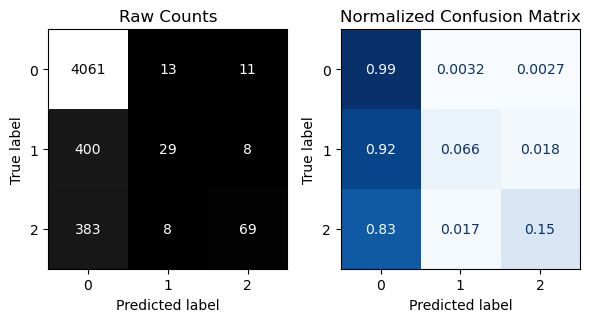


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1367
           1       0.22      0.03      0.05       150
           2       0.50      0.09      0.15       144

    accuracy                           0.82      1661
   macro avg       0.52      0.37      0.37      1661
weighted avg       0.75      0.82      0.76      1661



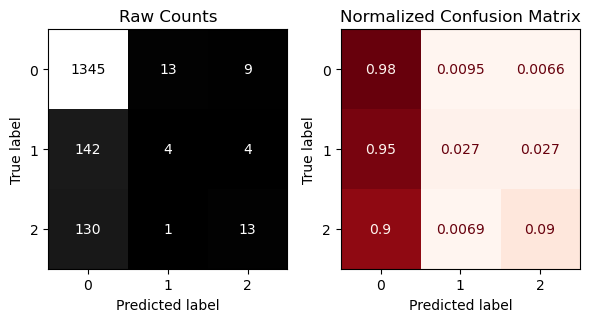

CPU times: total: 3.19 s
Wall time: 2.34 s


In [58]:
%%time

knn_pca_pipe = make_pipeline(scaler, pca, knn)

knn_pca_pipe.fit(X_train, y_train)

evaluate_classification(knn_pca_pipe, X_train, y_train, X_test, y_test)

In [24]:
knn_pca_pipe = KNeighborsClassifier()
knn_pca_pipe.fit(X_train_pca, y_train)

KNeighborsClassifier()

* ### ​Once fit, record the time it takes to make the predictions by using %%time as shown in the example below.​
  *  Record the time it takes to make predictions with PCA data

In [50]:
%%time
preds_pca = knn_pca.predict(X_test_pca)

CPU times: total: 1.39 s
Wall time: 278 ms


* ### Evaluate the model using multiple appropriate metrics `(we recommend using a custom evaluation function).`

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4085
           1       0.58      0.07      0.12       437
           2       0.78      0.15      0.25       460

    accuracy                           0.83      4982
   macro avg       0.73      0.40      0.43      4982
weighted avg       0.81      0.83      0.78      4982



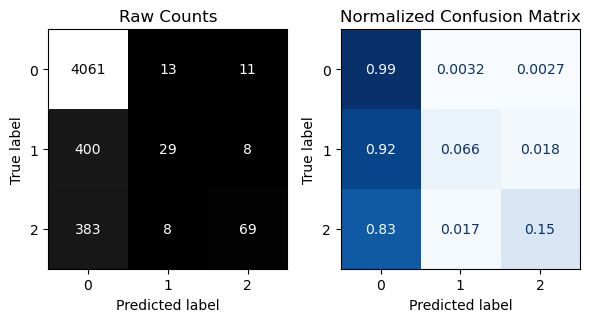


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1367
           1       0.22      0.03      0.05       150
           2       0.50      0.09      0.15       144

    accuracy                           0.82      1661
   macro avg       0.52      0.37      0.37      1661
weighted avg       0.75      0.82      0.76      1661



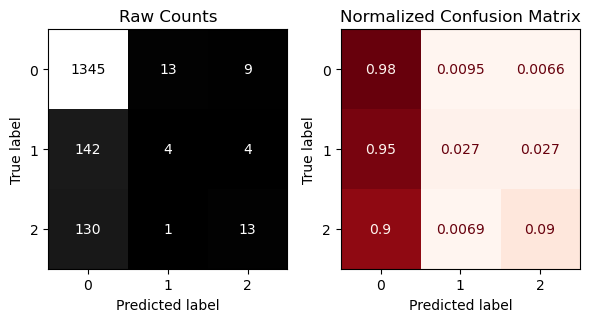

CPU times: total: 3.77 s
Wall time: 1.6 s


In [56]:
%%time
# evaluate the pipeline

evaluate_classification(knn_pca, X_train_pca, y_train, 
                 X_test_pca, y_test)

## `6. Compare the models`
* ### ​In a markdown cell at the end of your notebook, answer the following questions:    * #### Q1. How many features were used in the first model, and how many PCs were used in the PCA model? 


`In the 1st model I used 80, in the second ony 77 were used`

In [66]:
# No PCA
X_train.shape

(4982, 80)

In [67]:
# PCA
X_train_pca = preprocessor.fit_transform(X_train)
X_test_pca = preprocessor.transform(X_test)
X_train_pca.shape

(4982, 77)

*  #### Q2. Which model performed the best on the test set?

`They both perfomed similar but I see that PCA model perfomed at bit better on some parts but not all`

* #### Q3. Which model was the fastest at making predictions?

`The KNN model without PCA was the fastes at 3.19s vs the PCA at 3.77s`